In [8]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np
from shapely.geometry import box
from rasterio.mask import mask

import geopandas as gpd

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import ticker, cm

import matplotlib
import pandas as pd

In [9]:
plt.rcParams['hatch.linewidth'] = 0.25
plt.rcParams.update({"pdf.fonttype":42})

In [ ]:
geology = gpd.read_file('./maps/all_data.shp')
geology = geology[geology['unit_name'].notna()][geology[geology['unit_name'].notna()]['unit_name'].str.contains("Tuscarora")]

states = gpd.read_file("maps/states.shp")
physio = gpd.read_file("maps/physio.shp")

In [11]:
tile_data = pd.read_csv('output_data/tuscarora_tile_medians.csv')

tile_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(x=tile_data.longitude, y=tile_data.latitude), crs="EPSG:4326"
)

In [12]:
# Take the white out of the middle of this color map!!
n = 10
orig_cmap = plt.cm.BrBG_r
colors = np.vstack((
    orig_cmap(np.linspace(0, 0.3, n)),
    orig_cmap(np.linspace(.7, 1, n))
))
cmap_new = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

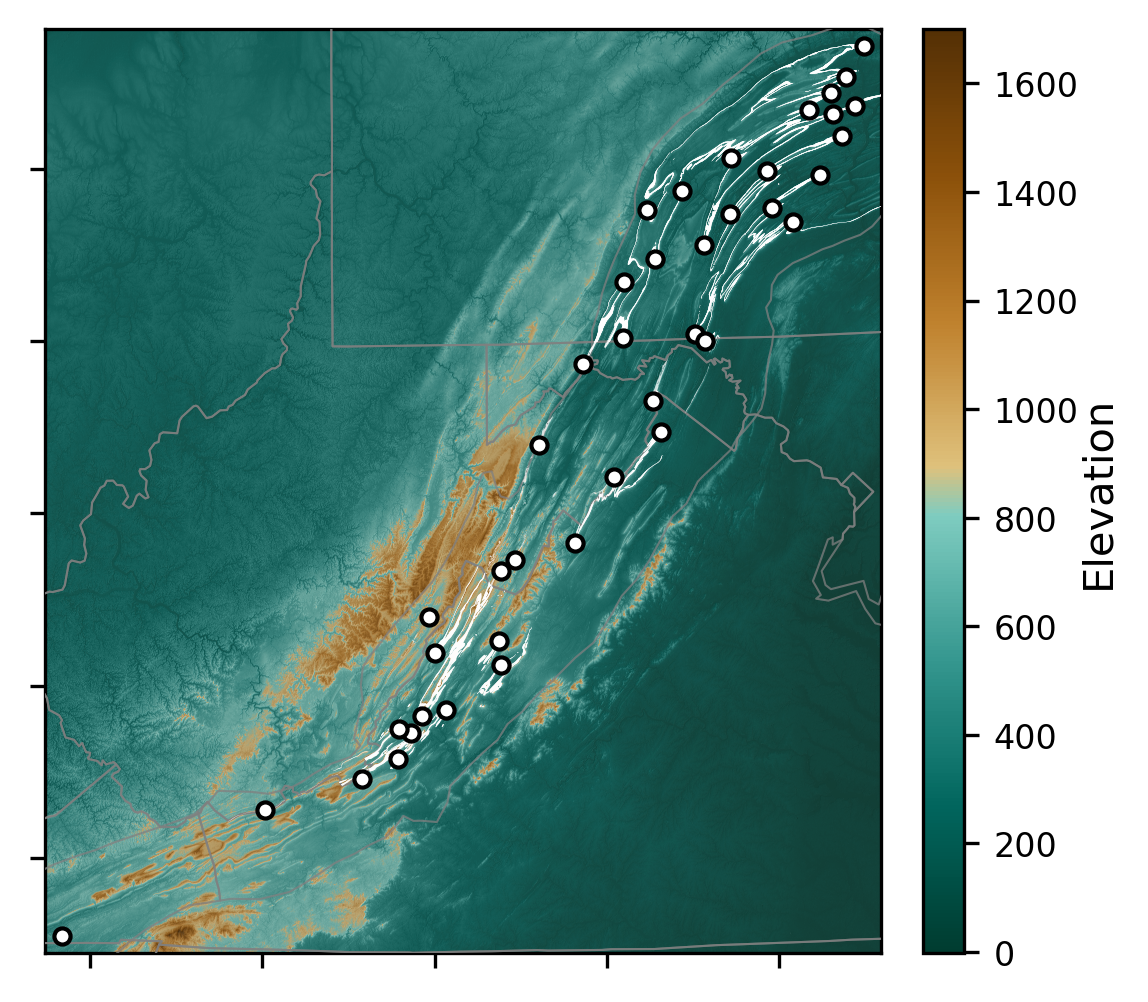

In [13]:
fig, ax = plt.subplots(figsize=(4,4), dpi=300)

with rasterio.open("maps/SRTMGL1_17N.tif", masked=True) as dem: 
    with rasterio.open("maps/SRTMGL1_17N_hs.tif", masked=True) as hs: 
        dem_read = dem.read(1)

        extent=[dem.bounds[0], dem.bounds[2], dem.bounds[1], dem.bounds[3]]


        im0 = plt.imshow(dem_read,
         extent=extent,
          vmin=-2,
           vmax=1700,
            cmap=cmap_new,
             alpha=1.0,
              zorder=0) 

        shade = show(
            hs, 
            extent=extent,
            alpha=0.5,
            cmap='binary', 
            ax=ax, zorder=1)  

        im = show(
            dem, 
          vmin=-2,
           vmax=1700,
            cmap=cmap_new,
            extent=extent,
            alpha=0.5,
            ax=ax, zorder=2
            )   

        states.to_crs(dem.crs).boundary.plot(
            alpha=0.75,
            color='gray',
            ax=ax,
            zorder=3,
            linewidth=0.5,
        )

        physio.loc[physio['PROVINCE']=='VALLEY AND RIDGE'].to_crs(dem.crs).boundary.plot(
            alpha=0.75,
            color='gray',
            ax=ax,
            zorder=3,
            linewidth=0.5,
        )

        geology.to_crs(dem.crs).plot(
                    alpha=0.75,
            color='white',
            ax=ax,
            zorder=4
        )
        
        data_bounds = tile_gdf.to_crs(dem.crs).total_bounds

        tile_gdf.to_crs(dem.crs).plot(
            ax=ax,
            color='white',
            edgecolor='k',
            zorder=5,
            markersize=15,
        )
        divider = make_axes_locatable(ax)
        # Add an axes to the right of the main axes.
        cax = divider.append_axes("right", size="5%", pad="5%")
        cb = fig.colorbar(im0, cax=cax, orientation='vertical')
        cb.set_label('Elevation', labelpad=0)
        cb.ax.tick_params(labelsize=8)

        ax.set_yticklabels([])
        ax.set_xticklabels([])

        ax.set_ylim((
            # extent[2]+100, extent[3]-100
            data_bounds[1]-10000, data_bounds[3]+10000
            ))
        ax.set_xlim((
            # extent[0]+100, extent[1]-100
            data_bounds[0]-10000, data_bounds[2]+10000
            ))
plt.savefig(f'./figure_outputs/overview_map.pdf')

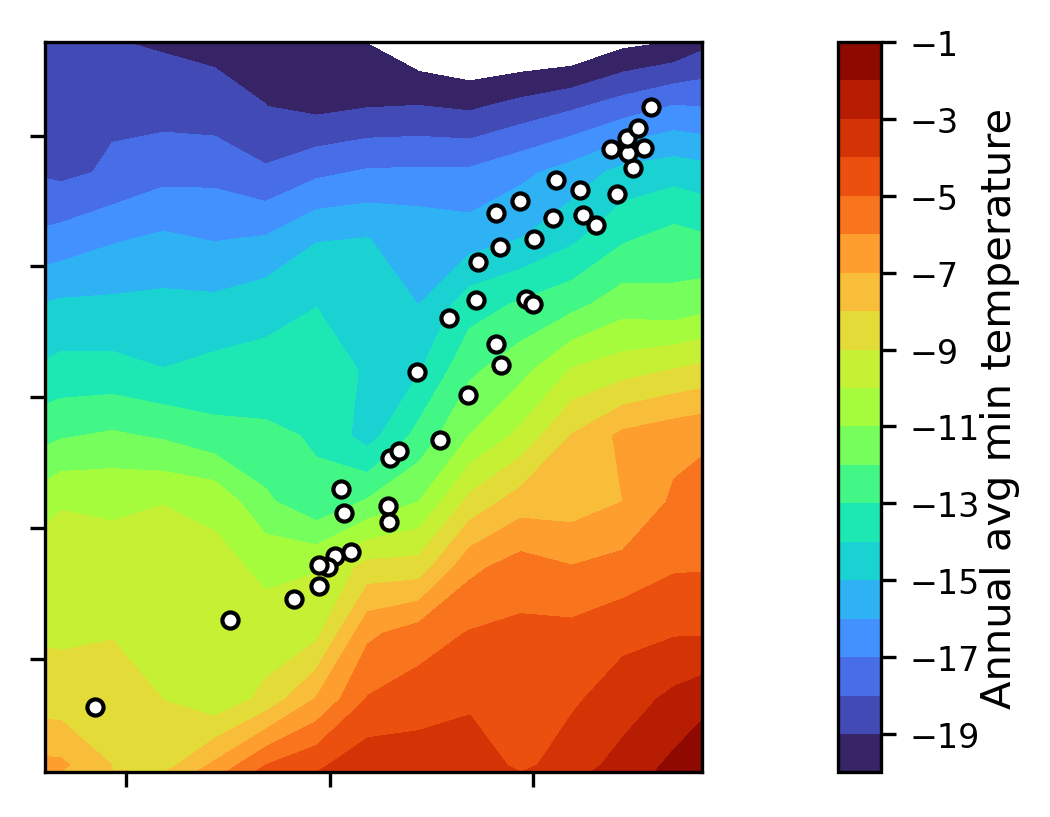

In [14]:
levels = np.arange(-20,0,1)
fig, ax = plt.subplots(figsize=(4,4), dpi=300)

with rasterio.open("maps/CCSM/22000BP/an_avg_TMIN.tif", masked=True) as src:
        src_read = src.read(1)
        src_read = np.ma.masked_where((src_read == src.nodatavals),src_read)

        extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]


        im0 = ax.contourf(src_read,
        # im0 = ax.contour(src_read,
        # This is the worst thing
         extent=(src.bounds[0], src.bounds[2], src.bounds[3], src.bounds[1]),
        #   vmin=-20,
        #    vmax=5,
            cmap='turbo',
            levels=levels,
             alpha=1.0,
              zorder=0,
              ) 

        # im0 = plt.imshow(src_read,
        #  extent=extent,
        #   vmin=-20,
        #    vmax=8,
        #     # cmap=cmap_new,
        #      alpha=1.0,
        #       zorder=0) 

        data_bounds = tile_gdf.to_crs(src.crs).total_bounds

        tile_gdf.to_crs(src.crs).plot(
            ax=ax,
            color='white',
            edgecolor='k',
            zorder=5,
            markersize=15,
        )

        # im = show(
        #     src, 
        #     contour=True,
        #   vmin=-20,
        #    vmax=20,
        #     # cmap=cmap_new,
        #     extent=extent,
        #     alpha=0.1,
        #     ax=ax, zorder=2
        #     )   

        divider = make_axes_locatable(ax)
        # Add an axes to the right of the main axes.
        cax = divider.append_axes("right", size="5%", pad="5%")
        cb = fig.colorbar(im0, cax=cax, orientation='vertical')
        cb.set_label('Annual avg min temperature', labelpad=0)
        cb.ax.tick_params(labelsize=8)

        ax.set_yticklabels([])
        ax.set_xticklabels([])

        ax.set_ylim((
            # extent[2]+100, extent[3]-100
            data_bounds[1]-0.5, data_bounds[3]+0.5
            ))
        ax.set_xlim((
            # extent[0]+100, extent[1]-100
            data_bounds[0]-0.5, data_bounds[2]+0.5
            ))
plt.savefig(f'./figure_outputs/tmin_lgm.pdf')

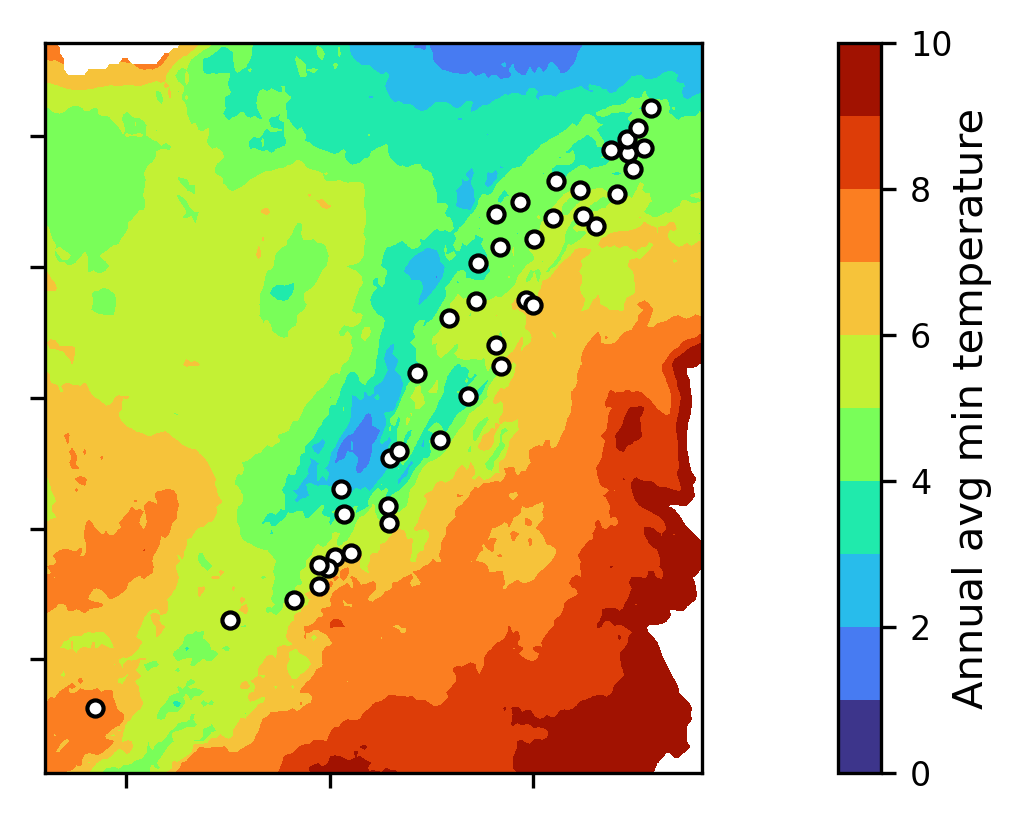

In [15]:
levels = np.arange(0,11,1)
fig, ax = plt.subplots(figsize=(4,4), dpi=300)

# with rasterio.open("maps/CCSM/22000BP/an_avg_TMIN.tif", masked=True) as src:
with rasterio.open("maps/PRISM/PRISM_tmin_30yr_normal_4kmM5_annual_bil.bil", masked=True) as src:
        src_read = src.read(1)
        src_read = np.ma.masked_where((src_read == src.nodatavals),src_read)

        extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]


        im0 = ax.contourf(src_read,
        # im0 = ax.contour(src_read,
        # This is the worst thing
         extent=(src.bounds[0], src.bounds[2], src.bounds[3], src.bounds[1]),
        #   vmin=-20,
        #    vmax=5,
            cmap='turbo',
            levels=levels,
             alpha=1.0,
              zorder=0,
              ) 

        # im0 = plt.imshow(src_read,
        #  extent=extent,
        #   vmin=-20,
        #    vmax=8,
        #     # cmap=cmap_new,
        #      alpha=1.0,
        #       zorder=0) 

        data_bounds = tile_gdf.to_crs(src.crs).total_bounds

        tile_gdf.to_crs(src.crs).plot(
            ax=ax,
            color='white',
            edgecolor='k',
            zorder=5,
            markersize=15,
        )

        # im = show(
        #     src, 
        #     contour=True,
        #   vmin=-20,
        #    vmax=20,
        #     # cmap=cmap_new,
        #     extent=extent,
        #     alpha=0.1,
        #     ax=ax, zorder=2
        #     )   

        divider = make_axes_locatable(ax)
        # Add an axes to the right of the main axes.
        cax = divider.append_axes("right", size="5%", pad="5%")
        cb = fig.colorbar(im0, cax=cax, orientation='vertical')
        cb.set_label('Annual avg min temperature', labelpad=0)
        cb.ax.tick_params(labelsize=8)

        ax.set_yticklabels([])
        ax.set_xticklabels([])

        ax.set_ylim((
            # extent[2]+100, extent[3]-100
            data_bounds[1]-0.5, data_bounds[3]+0.5
            ))
        ax.set_xlim((
            # extent[0]+100, extent[1]-100
            data_bounds[0]-0.5, data_bounds[2]+0.5
            ))
plt.savefig(f'./figure_outputs/tmin_present.pdf')

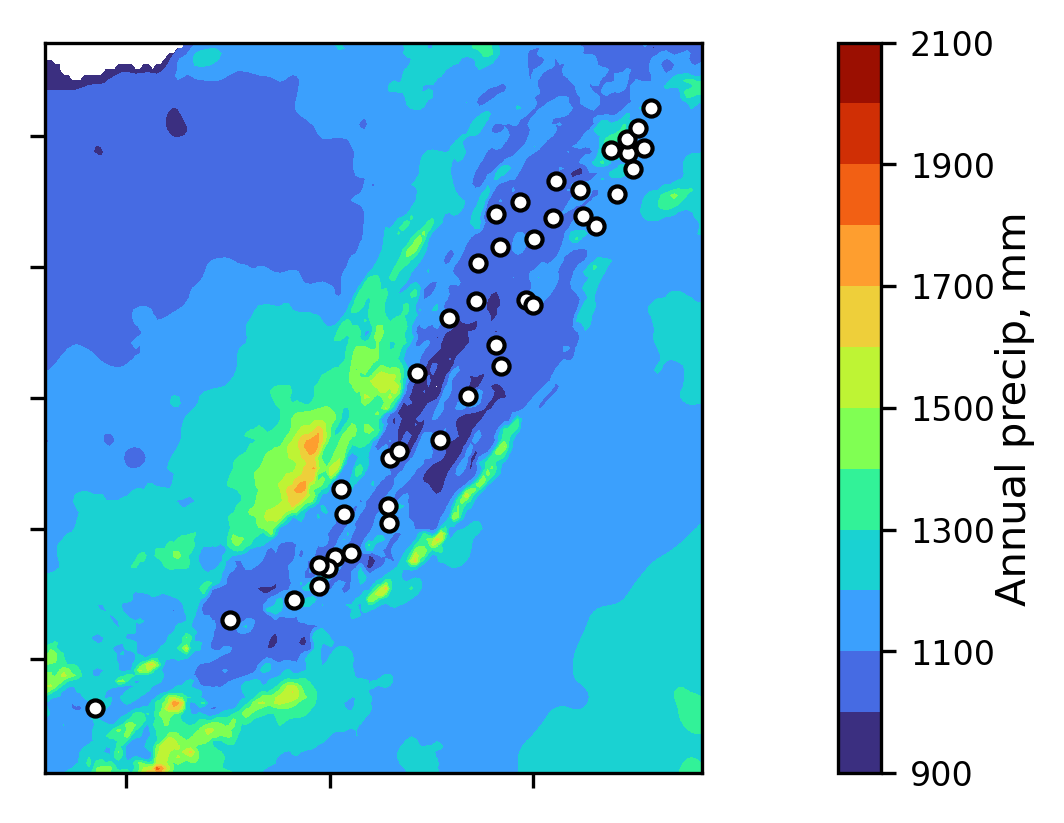

In [16]:
levels = np.arange(900,2200,100)
fig, ax = plt.subplots(figsize=(4,4), dpi=300)
# app-dd/appalachia/maps/PRISM/PRISM_ppt_30yr_normal_4kmM4_annual_bil.bil

# with rasterio.open("maps/CCSM/22000BP/an_sum_PRCP.tif", masked=True) as src:
with rasterio.open("maps/PRISM/PRISM_ppt_30yr_normal_4kmM4_annual_bil.bil", masked=True) as src:
        src_read = src.read(1)
        src_read = np.ma.masked_where((src_read == src.nodatavals),src_read)

        extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]


        im0 = ax.contourf(src_read,
        # im0 = ax.contour(src_read,
        # This is the worst thing
         extent=(src.bounds[0], src.bounds[2], src.bounds[3], src.bounds[1]),
        #   vmin=-20,
        #    vmax=20,
            cmap='turbo',
            levels=levels,
             alpha=1.0,
              zorder=0,
              ) 

        # im0 = plt.imshow(src_read,
        #  extent=extent,
        #   vmin=-20,
        #    vmax=20,
        #     # cmap=cmap_new,
        #      alpha=1.0,
        #       zorder=0) 

        data_bounds = tile_gdf.to_crs(src.crs).total_bounds

        tile_gdf.to_crs(src.crs).plot(
            ax=ax,
            color='white',
            edgecolor='k',
            zorder=5,
            markersize=15,
        )

        # im = show(
        #     src, 
        #     contour=True,
        #   vmin=-20,
        #    vmax=20,
        #     # cmap=cmap_new,
        #     extent=extent,
        #     alpha=0.1,
        #     ax=ax, zorder=2
        #     )   

        divider = make_axes_locatable(ax)
        # Add an axes to the right of the main axes.
        cax = divider.append_axes("right", size="5%", pad="5%")
        cb = fig.colorbar(im0, cax=cax, orientation='vertical')
        cb.set_label('Annual precip, mm', labelpad=0)
        cb.ax.tick_params(labelsize=8)

        ax.set_yticklabels([])
        ax.set_xticklabels([])

        ax.set_ylim((
            # extent[2]+100, extent[3]-100
            data_bounds[1]-0.5, data_bounds[3]+0.5
            ))
        ax.set_xlim((
            # extent[0]+100, extent[1]-100
            data_bounds[0]-0.5, data_bounds[2]+0.5
            ))
plt.savefig(f'./figure_outputs/ppt_prism.pdf')

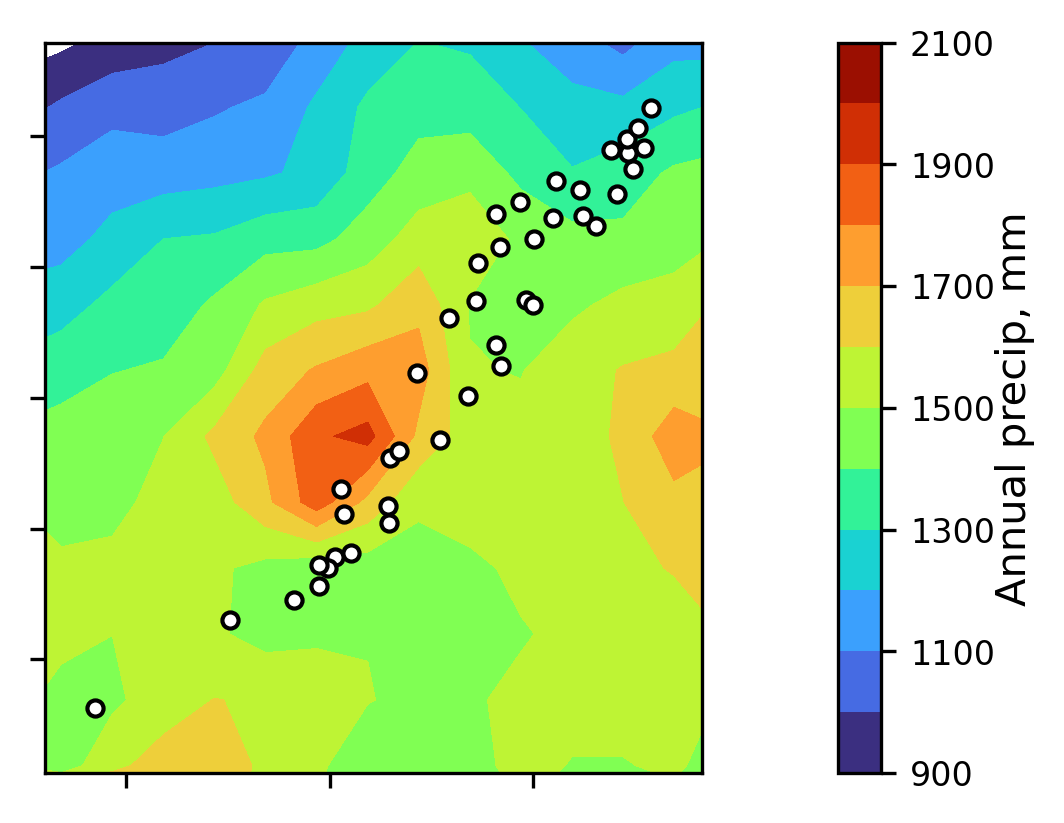

In [17]:
levels = np.arange(900,2200,100)
fig, ax = plt.subplots(figsize=(4,4), dpi=300)
# app-dd/appalachia/maps/PRISM/PRISM_ppt_30yr_normal_4kmM4_annual_bil.bil

with rasterio.open("maps/CCSM/22000BP/an_sum_PRCP.tif", masked=True) as src:
# with rasterio.open("maps/PRISM/PRISM_ppt_30yr_normal_4kmM4_annual_bil.bil", masked=True) as src:
        src_read = src.read(1)
        src_read = np.ma.masked_where((src_read == src.nodatavals),src_read)

        extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]


        im0 = ax.contourf(src_read,
        # im0 = ax.contour(src_read,
        # This is the worst thing
         extent=(src.bounds[0], src.bounds[2], src.bounds[3], src.bounds[1]),
        #   vmin=-20,
        #    vmax=20,
            cmap='turbo',
            levels=levels,
             alpha=1.0,
              zorder=0,
              ) 

        # im0 = plt.imshow(src_read,
        #  extent=extent,
        #   vmin=-20,
        #    vmax=20,
        #     # cmap=cmap_new,
        #      alpha=1.0,
        #       zorder=0) 

        data_bounds = tile_gdf.to_crs(src.crs).total_bounds

        tile_gdf.to_crs(src.crs).plot(
            ax=ax,
            color='white',
            edgecolor='k',
            zorder=5,
            markersize=15,
        )

        # im = show(
        #     src, 
        #     contour=True,
        #   vmin=-20,
        #    vmax=20,
        #     # cmap=cmap_new,
        #     extent=extent,
        #     alpha=0.1,
        #     ax=ax, zorder=2
        #     )   

        divider = make_axes_locatable(ax)
        # Add an axes to the right of the main axes.
        cax = divider.append_axes("right", size="5%", pad="5%")
        cb = fig.colorbar(im0, cax=cax, orientation='vertical')
        cb.set_label('Annual precip, mm', labelpad=0)
        cb.ax.tick_params(labelsize=8)

        ax.set_yticklabels([])
        ax.set_xticklabels([])

        ax.set_ylim((
            # extent[2]+100, extent[3]-100
            data_bounds[1]-0.5, data_bounds[3]+0.5
            ))
        ax.set_xlim((
            # extent[0]+100, extent[1]-100
            data_bounds[0]-0.5, data_bounds[2]+0.5
            ))
plt.savefig(f'./figure_outputs/ppt_lgm.pdf')